# Comparing Ab-Ag complex structure predictions

## Imports

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import Bio
from Bio import PDB
from Bio.Align import PairwiseAligner
from Bio.PDB import PDBParser, MMCIFParser, StructureBuilder
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.Polypeptide import PPBuilder
from Bio.Seq import Seq
from Bio.SeqUtils import seq1
from Bio.SeqIO import parse
from scipy.spatial import KDTree
from DockQ.DockQ import load_PDB, run_on_all_native_interfaces


/anaconda/envs/dockq/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [9]:
def get_contacts(chain1, chain2, cutoff=5.0):
    if not isinstance(chain1, list):
        atoms1 = [atom for atom in chain1.get_atoms() if atom.element != 'H']
    else:
        atoms1 = [atom for res in chain1 for atom in res.get_atoms()]
    if not isinstance(chain2, list):
        atoms2 = [atom for atom in chain2.get_atoms() if atom.element != 'H']
    else:
        atoms2 = chain2
    contacts = []
    for atom1 in atoms1:
        for atom2 in atoms2:
            if atom1 - atom2 < cutoff:
                contacts.append((atom1, atom2))
    return contacts

def get_cdr_residues(chain, cdr_ranges):
    cdr_residues = []
    for start, end in cdr_ranges:
        for residue in chain:
            if start <= residue.id[1] <= end:
                cdr_residues.append(residue)

    return cdr_residues

def get_atom_coordinates(residues):
    atoms = [atom for residue in residues for atom in residue.get_atoms() if atom.element != 'H']
    coords =  np.array([atom.coord for atom in atoms])
    return atoms, coords

def identify_antibody_chains(pdb_file, heavy_chain_seq, light_chain_seq, verbose=False):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    heavy_cdr_ranges=[(27,38), (56,65), (105,117)]
    light_cdr_ranges=[(27,38), (56,65), (105,117)]
    cutoff=5.0

    pdb = PPBuilder()
    chain_sequences = dict()

    chain_coords_dict = dict()
    for model in structure:
        for chain in model:
            seq = ''.join([seq1(residue.resname) for residue in chain if PDB.is_aa(residue, standard=True)])
            if len(seq) > 20:
                chain_sequences[chain.id] = seq
                chain_atoms = [atom for atom in chain.get_atoms() if atom.element != 'H']
                chain_coords = np.array([atom.coord for atom in chain_atoms])
                chain_coords_dict[chain.id] = chain_coords

    heavy_chain_id, light_chain_id = [], []
    for chain_id, sequence in chain_sequences.items():
        if heavy_chain_seq in sequence or sequence in heavy_chain_seq:
            heavy_chain_id.append(chain_id)
        elif light_chain_seq in sequence or sequence in light_chain_seq:
            light_chain_id.append(chain_id)

    if heavy_chain_id is None or light_chain_id is None:
        raise ValueError('could not identify heavy or light chain')
    
    paired_chains = dict()
    if verbose:
        print('Pairing antibody chains')

    for hc_id in heavy_chain_id:
        heavy_chain = structure[0][hc_id]
        vh_residues = get_cdr_residues(heavy_chain, [(1,128)])
        heavy_atoms, heavy_coords = get_atom_coordinates(vh_residues)
        heavy_tree = KDTree(heavy_coords)
        for lc_id in light_chain_id:
            light_chain = structure[0][lc_id]
            vl_residues = get_cdr_residues(light_chain, [(1,128)])
            light_atoms, light_coords = get_atom_coordinates(vl_residues)
            contacts = heavy_tree.query_ball_point(light_coords, cutoff)
            total_contacts = sum([len(contact) for contact in contacts])

            if total_contacts > 0:
                paired_chains[(hc_id, lc_id)] = []
                break

    if verbose:
        print('Finding antigen per antibody complex')
    
    for hc_id, lc_id in paired_chains.keys():
        heavy_chain = structure[0][hc_id]
        light_chain = structure[0][lc_id]
        heavy_cdr_residues = get_cdr_residues(heavy_chain, heavy_cdr_ranges)
        light_cdr_residues = get_cdr_residues(light_chain, light_cdr_ranges)
        heavy_atoms, heavy_coords = get_atom_coordinates(heavy_cdr_residues)
        light_atoms, light_coords = get_atom_coordinates(light_cdr_residues)

        heavy_tree = KDTree(heavy_coords)
        light_tree = KDTree(light_coords)

        for model in structure:
            for chain in model:
                if chain.id in heavy_chain_id + light_chain_id:
                    continue
                if chain.id not in chain_sequences.keys():
                    continue

                chain_coords = chain_coords_dict[chain.id]
                heavy_contacts = heavy_tree.query_ball_point(chain_coords, cutoff)
                light_contacts = light_tree.query_ball_point(chain_coords, cutoff)

                total_contacts = sum(len(contact) for contact in heavy_contacts) + sum(len(contact) for contact in light_contacts)

                if total_contacts > 0:
                    paired_chains[(hc_id, lc_id)].append((chain.id, total_contacts))

        for ab_pair, ag_list in paired_chains.items():
            if len(ag_list) == 0:
                ag = None
            elif len(ag_list) > 1:
                ag = sorted(ag_list, key=lambda x: x[1], reverse=True)[0]
            else:
                ag = ag_list[0]
            paired_chains[ab_pair] = ag

        return paired_chains

In [10]:
pdb_parser = PDBParser()
aligner  = PairwiseAligner()
aligner.gap_score = -2
aligner.left_gap_score = 0
aligner.right_gap_score = 0

In [11]:
struc_pair = {}
work_dir = '../data/interim/True_structures'
for mol in os.listdir(work_dir):
    name = mol[:-4].upper()
    print(name)
    seqs = []
    for record in parse(f'../data/interim/boltz_input/{name}.fasta', 'fasta'):
        seqs.append(str(record.seq))
    native = pdb_parser.get_structure(name, os.path.join(work_dir, mol))
    pairings = identify_antibody_chains(os.path.join(work_dir, mol), seqs[0], seqs[1])
    struc_pair[name] = pairings
    # break

    # mol_df = parse('')

2G75
2GHW


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7017.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7067.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7111.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7155.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7486.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous

3BGF


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 10190.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 10191.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10193.
  warnings.warn(


4XAK


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21077.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 21105.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21117.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21145.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 21193.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is disconti

4ZPT


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain R is discontinuous at line 20120.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain S is discontinuous at line 20148.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 20176.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 20251.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain R is discontinuous at line 20306.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is disconti

4ZS6


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 20443.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 20499.
  warnings.warn(


5DO2


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 20765.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 20803.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 20834.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 20863.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 20886.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is disconti

5GMQ


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5449.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5485.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5489.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5494.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5497.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous

5YY5
5ZXV
6C6X


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27730.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27861.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 27947.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 28127.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 28256.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain F is disconti

6NB3


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31642.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 32423.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 33082.
  warnings.warn(


6NB6


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27690.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 28327.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28948.
  warnings.warn(


6W41
6WPS


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 5441.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5457.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 29904.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 30241.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 30578.
  warnings.warn(


6XC2


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10312.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain Z is discontinuous at line 10326.
  warnings.warn(


6XC4


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10420.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain Z is discontinuous at line 10434.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10448.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 10531.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 10671.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain Z is disconti

6XCA
6XDG


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10085.
  warnings.warn(


6XE1


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 5460.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 5468.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 5478.
  warnings.warn(


6XEY


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 30597.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 30860.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31120.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 31380.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 31408.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain J is disconti

6XKP


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10175.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10189.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 10203.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 10218.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain M is discontinuous at line 10228.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain N is disconti

6XKQ


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9428.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 9456.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9484.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 9528.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 9570.
  warnings.warn(


6ZCZ


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 12608.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 12623.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 12624.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 12626.
  warnings.warn(


7AKD


/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 29244.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 29380.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 29558.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 29666.
  warnings.warn(
/anaconda/envs/dockq/lib/python3.13/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 29677.
  warnings.warn(


In [12]:
struc_pair

{'2G75': None,
 '2GHW': None,
 '3BGF': {('H', 'L'): ('S', 105), ('B', 'C'): None},
 '4XAK': {('H', 'L'): ('A', 134), ('D', 'E'): None},
 '4ZPT': {('A', 'B'): ('R', 146), ('H', 'L'): None},
 '4ZS6': None,
 '5DO2': {('H', 'L'): ('A', 165), ('C', 'D'): None},
 '5GMQ': {('B', 'C'): ('A', 171)},
 '5YY5': {('H', 'L'): ('A', 138)},
 '5ZXV': None,
 '6C6X': {('A', 'B'): None,
  ('C', 'B'): None,
  ('E', 'F'): None,
  ('H', 'F'): None},
 '6NB3': {('H', 'L'): ('C', 233), ('D', 'E'): None},
 '6NB6': {('H', 'L'): ('C', 49), ('I', 'M'): None},
 '6W41': {('H', 'L'): ('C', 218)},
 '6WPS': None,
 '6XC2': {('H', 'L'): ('A', 384), ('X', 'Y'): None},
 '6XC4': {('H', 'L'): ('A', 239), ('X', 'Y'): None},
 '6XCA': None,
 '6XDG': None,
 '6XE1': None,
 '6XEY': {('F', 'G'): ('B', 92), ('H', 'L'): None, ('J', 'K'): None},
 '6XKP': None,
 '6XKQ': None,
 '6ZCZ': {('H', 'L'): ('E', 234)},
 '7AKD': {('D', 'E'): ('C', 50), ('H', 'L'): None}}

In [17]:
dockqs = [[], []]
irmsd = [[], []]
scores = [[], []]
f1 = [[], []]
epitope = []
# F1
for i, (mol_name, pairings) in enumerate(struc_pair.items()):
    if pairings is None:
        continue
    for hl_pairing, rbd_chain in pairings.items():
        if rbd_chain is None:
            continue
        
        epitope.append(os.listdir('../data/interim/queries_H')[i].split('_')[1])
        chain_map = {hl_pairing[0]: 'A', hl_pairing[1]: 'B', rbd_chain[0]: 'C'}
        # chain_map = {'C*':rbd_chain[0]+'*'}
        print(chain_map)
        native = load_PDB(f'../data/interim/True_structures/{mol_name.lower()}.pdb')
        baseline = load_PDB(f'../data/interim/boltz_results_baseline/boltz_results_{mol_name}/predictions/{mol_name}/{mol_name}_model_0.cif')
        custom = load_PDB(f'../data/interim/boltz_custom_results/boltz_results_{mol_name}/predictions/{mol_name}/{mol_name}_model_0.cif')
        base_res = run_on_all_native_interfaces(baseline, native, chain_map=chain_map)
        custom_res = run_on_all_native_interfaces(custom, native, chain_map=chain_map)
        dockqs[0].append(1/2 * (base_res[0][hl_pairing[0]+rbd_chain[0]]['DockQ'] + base_res[0][hl_pairing[1]+rbd_chain[0]]['DockQ']))
        dockqs[1].append(1/2 * (custom_res[0][hl_pairing[0]+rbd_chain[0]]['DockQ'] + custom_res[0][hl_pairing[1]+rbd_chain[0]]['DockQ']))
        irmsd[0].append(1/2 * (base_res[0][hl_pairing[0]+rbd_chain[0]]['iRMSD'] + base_res[0][hl_pairing[1]+rbd_chain[0]]['iRMSD']))
        irmsd[1].append(1/2 * (custom_res[0][hl_pairing[0]+rbd_chain[0]]['iRMSD'] + custom_res[0][hl_pairing[1]+rbd_chain[0]]['iRMSD']))
        f1[0].append(1/2 * (base_res[0][hl_pairing[0]+rbd_chain[0]]['F1'] + base_res[0][hl_pairing[1]+rbd_chain[0]]['F1']))
        f1[1].append(1/2 * (custom_res[0][hl_pairing[0]+rbd_chain[0]]['F1'] + custom_res[0][hl_pairing[1]+rbd_chain[0]]['F1']))

        

{'H': 'A', 'L': 'B', 'S': 'C'}
{'H': 'A', 'L': 'B', 'A': 'C'}
{'A': 'A', 'B': 'B', 'R': 'C'}
{'H': 'A', 'L': 'B', 'A': 'C'}
{'B': 'A', 'C': 'B', 'A': 'C'}
{'H': 'A', 'L': 'B', 'A': 'C'}
{'H': 'A', 'L': 'B', 'C': 'C'}
{'H': 'A', 'L': 'B', 'C': 'C'}
{'H': 'A', 'L': 'B', 'C': 'C'}
{'H': 'A', 'L': 'B', 'A': 'C'}
{'H': 'A', 'L': 'B', 'A': 'C'}
{'F': 'A', 'G': 'B', 'B': 'C'}
{'H': 'A', 'L': 'B', 'E': 'C'}
{'D': 'A', 'E': 'B', 'C': 'C'}


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric(scores, metric, epitopes):
    plt.boxplot(scores, tick_labels=['Base Boltz-1', 'Custom MSA Boltz-1'], showfliers=False)
    x_base = np.random.normal(1, 0.15, len(scores[0]))
    x_custom = np.random.normal(2, 0.15, len(scores[1]))
    for epitope in np.unique(epitopes):
        idx = np.array(epitopes) == epitope
        idx2 = np.concatenate([idx, idx])
        x_all = np.concatenate([x_base, x_custom])
        # print(idx)
        plt.scatter([x for x, y in zip(x_all, idx2) if y], [x for x, y in zip(scores[0] + scores[1], idx2) if y], label=epitope)
        # plt.scatter([x for x, y in zip(x_custom, idx) if y], [x for x, y in zip(scores[1], idx) if y], label=epitope)

    for i, (x1, x2) in enumerate(zip(x_base, x_custom)):
        plt.plot([x1, x2], [scores[0][i], scores[1][i]], color='k', alpha=0.3)

    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} docking score')
    plt.legend()
    plt.show()
    # plt.yscale('log')

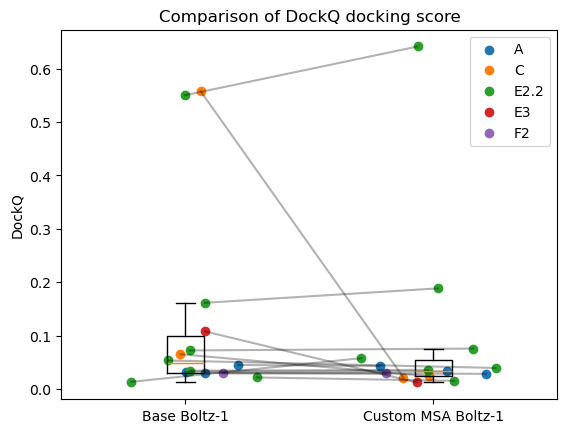

In [25]:
plot_metric(dockqs, 'DockQ', epitope)

In [80]:
np.array(epitope) == 'E2.2'

array([ True,  True, False, False, False,  True, False,  True, False,
        True, False,  True, False,  True])

In [81]:
np.repeat(np.array(epitope) == 'E2.2', 2)

array([ True,  True,  True,  True, False, False, False, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
        True,  True, False, False,  True,  True, False, False,  True,
        True])

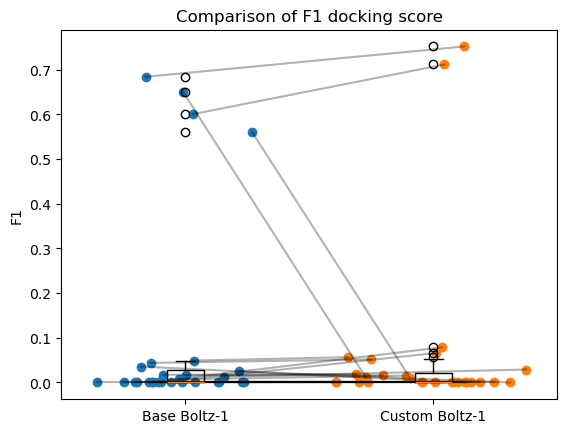

In [45]:
plot_metric(f1, 'F1')

In [89]:
print(dockqs[0][-1], dockqs[1][-1])

0.014284942343189758 0.0477181531858957


In [24]:
print(base_res[0]['DC'])
print(base_res[0]['EC'])

{'DockQ': 0.014357062077157054, 'F1': 0.0, 'iRMSD': 11.85231525134005, 'LRMSD': 50.73070725918304, 'fnat': 0, 'nat_correct': 0, 'nat_total': 36, 'fnonnat': 1.0, 'nonnat_count': 51, 'model_total': 51, 'clashes': 3, 'len1': 120, 'len2': 992, 'class1': 'ligand', 'class2': 'receptor', 'is_het': False, 'chain1': 'A', 'chain2': 'C', 'chain_map': {'D': 'A', 'E': 'B', 'C': 'C'}}
{'DockQ': 0.01249890988751729, 'F1': 0.0, 'iRMSD': 12.487169159862674, 'LRMSD': 55.066226969939514, 'fnat': 0, 'nat_correct': 0, 'nat_total': 10, 'fnonnat': 1.0, 'nonnat_count': 3, 'model_total': 3, 'clashes': 0, 'len1': 106, 'len2': 992, 'class1': 'ligand', 'class2': 'receptor', 'is_het': False, 'chain1': 'B', 'chain2': 'C', 'chain_map': {'D': 'A', 'E': 'B', 'C': 'C'}}


In [23]:
print(custom_res[0]['DC'])
print(custom_res[0]['EC'])

{'DockQ': 0.09057454779258274, 'F1': 0.15730337078651685, 'iRMSD': 11.700301802837911, 'LRMSD': 33.31754207660045, 'fnat': 0.19444444444444445, 'nat_correct': 7, 'nat_total': 36, 'fnonnat': 0.8679245283018868, 'nonnat_count': 46, 'model_total': 53, 'clashes': 4, 'len1': 120, 'len2': 992, 'class1': 'ligand', 'class2': 'receptor', 'is_het': False, 'chain1': 'A', 'chain2': 'C', 'chain_map': {'D': 'A', 'E': 'B', 'C': 'C'}}
{'DockQ': 0.024964181378004196, 'F1': 0.0, 'iRMSD': 13.802561902080493, 'LRMSD': 32.719776895906925, 'fnat': 0, 'nat_correct': 0, 'nat_total': 10, 'fnonnat': 1.0, 'nonnat_count': 19, 'model_total': 19, 'clashes': 1, 'len1': 106, 'len2': 992, 'class1': 'ligand', 'class2': 'receptor', 'is_het': False, 'chain1': 'B', 'chain2': 'C', 'chain_map': {'D': 'A', 'E': 'B', 'C': 'C'}}


In [39]:
custom_res[0]['BC']

{'DockQ': 0.02542624076484397,
 'F1': 0.0,
 'iRMSD': 13.040333857759537,
 'LRMSD': 32.719753244156514,
 'fnat': 0,
 'nat_correct': 0,
 'nat_total': 19,
 'fnonnat': 1.0,
 'nonnat_count': 10,
 'model_total': 10,
 'clashes': 0,
 'len1': 106,
 'len2': 223,
 'class1': 'ligand',
 'class2': 'receptor',
 'is_het': False,
 'chain1': 'E',
 'chain2': 'C',
 'chain_map': {'A': 'D', 'B': 'E', 'C': 'C'}}